Обработанные документы:
Документ 1: ['cat', 'sat', 'mat']
Документ 2: ['dog', 'played', 'garden']
Документ 3: ['cats', 'dogs', 'pets']
Документ 4: ['mat', 'floor']
Документ 5: ['dogs', 'like', 'play', 'gardens']

BM25 Scores для запроса 'cat and dog':
Документ 1: 'The cat sat on the mat' → Score: 1.3863
Документ 2: 'The dog played in the garden' → Score: 1.3863
Документ 3: 'Cats and dogs are pets' → Score: 0.0000
Документ 4: 'The mat is on the floor' → Score: 0.0000
Документ 5: 'Dogs like to play in gardens' → Score: 0.0000


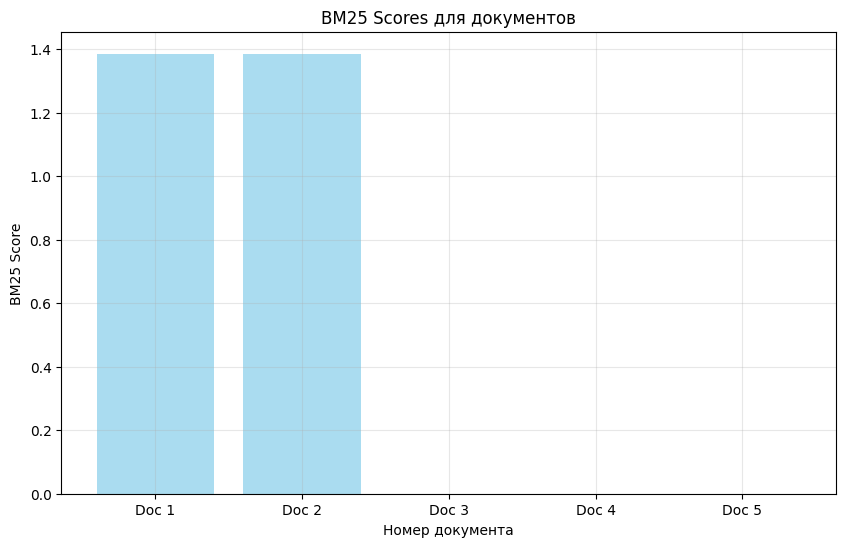

In [2]:
import numpy as np
import math
from collections import Counter
import re

class BM25:
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.documents = []
        self.avgdl = 0
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = []
        self.corpus_size = 0

    def fit(self, documents):
        """Обучение модели на коллекции документов"""
        self.documents = documents
        self.corpus_size = len(documents)
        self.doc_len = [len(doc) for doc in documents]
        self.avgdl = np.mean(self.doc_len)

        # Вычисление частот терминов в документах
        tf = []
        df = {}

        for doc in documents:
            frequencies = {}
            for word in doc:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1

                if word not in df:
                    df[word] = 0
                df[word] += 1
            tf.append(frequencies)

        self.doc_freqs = tf

        # Вычисление IDF для каждого термина
        for word, freq in df.items():
            self.idf[word] = math.log(
                (self.corpus_size - freq + 0.5) / (freq + 0.5) + 1
            )

    def get_score(self, document, query, index):
        """Вычисление BM25 score для одного документа"""
        score = 0.0

        for word in query:
            if word not in self.doc_freqs[index]:
                continue

            # Term Frequency в документе
            tf = self.doc_freqs[index][word]

            # Inverse Document Frequency
            idf = self.idf.get(word, 0)

            # Вычисление компонента TF с насыщением
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * (1 - self.b + self.b * self.doc_len[index] / self.avgdl)

            score += idf * numerator / denominator

        return score

    def get_scores(self, query):
        """Вычисление BM25 scores для всех документов"""
        scores = np.zeros(self.corpus_size)

        for i in range(self.corpus_size):
            scores[i] = self.get_score(self.documents[i], query, i)

        return scores

def simple_tokenize(text):
    """Простая токенизация без NLTK"""
    # Приводим к нижнему регистру и разбиваем по словам
    words = re.findall(r'\b\w+\b', text.lower())

    # Простой список стоп-слов
    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they'
    }

    # Фильтруем стоп-слова и короткие слова
    tokens = [word for word in words if word not in stop_words and len(word) > 2]
    return tokens

# Пример документов
documents = [
    "The cat sat on the mat",
    "The dog played in the garden",
    "Cats and dogs are pets",
    "The mat is on the floor",
    "Dogs like to play in gardens"
]

# Предобработка документов с простой токенизацией
processed_docs = [simple_tokenize(doc) for doc in documents]

print("Обработанные документы:")
for i, doc in enumerate(processed_docs):
    print(f"Документ {i+1}: {doc}")

# Создание и обучение модели BM25
bm25 = BM25(k1=1.5, b=0.75)
bm25.fit(processed_docs)

# Запрос
query = simple_tokenize("cat and dog")

# Получение оценок
scores = bm25.get_scores(query)

# Вывод результатов
print("\nBM25 Scores для запроса 'cat and dog':")
for i, (doc, score) in enumerate(zip(documents, scores)):
    print(f"Документ {i+1}: '{doc}' → Score: {score:.4f}")

# Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(scores)), scores, color='skyblue', alpha=0.7)
plt.title('BM25 Scores для документов')
plt.xlabel('Номер документа')
plt.ylabel('BM25 Score')
plt.xticks(range(len(scores)), [f'Doc {i+1}' for i in range(len(scores))])
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# Сначала установим и загрузим нужные данные
import nltk
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')  # Новая версия punkt
except:
    print("Проблемы с загрузкой NLTK данных, используем альтернативный метод")

def robust_preprocess_text(text):
    """Надежная предобработка текста с обработкой ошибок"""
    try:
        # Пробуем использовать NLTK
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords

        tokens = word_tokenize(text.lower())
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        return tokens
    except:
        # Если NLTK не работает, используем простую токенизацию
        return simple_tokenize(text)

# Альтернатива: использование других библиотек
def using_spacy_tokenization():
    """Использование spaCy для токенизации (если установлен)"""
    try:
        import spacy
        nlp = spacy.load("en_core_web_sm")

        def spacy_tokenize(text):
            doc = nlp(text.lower())
            return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

        return spacy_tokenize
    except:
        return simple_tokenize

# Тестирование обоих методов
print("=== Тестирование BM25 с разными методами токенизации ===")

# Метод 1: Простая токенизация
print("\n1. Простая токенизация:")
processed_simple = [simple_tokenize(doc) for doc in documents]
bm25_simple = BM25()
bm25_simple.fit(processed_simple)
scores_simple = bm25_simple.get_scores(simple_tokenize("cat and dog"))

for i, (doc, score) in enumerate(zip(documents, scores_simple)):
    print(f"  Документ {i+1}: {score:.4f}")

# Метод 2: Robust токенизация (пробует NLTK, потом простой метод)
print("\n2. Robust токенизация:")
processed_robust = [robust_preprocess_text(doc) for doc in documents]
bm25_robust = BM25()
bm25_robust.fit(processed_robust)
scores_robust = bm25_robust.get_scores(robust_preprocess_text("cat and dog"))

for i, (doc, score) in enumerate(zip(documents, scores_robust)):
    print(f"  Документ {i+1}: {score:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


=== Тестирование BM25 с разными методами токенизации ===

1. Простая токенизация:
  Документ 1: 1.3863
  Документ 2: 1.3863
  Документ 3: 0.0000
  Документ 4: 0.0000
  Документ 5: 0.0000

2. Robust токенизация:
  Документ 1: 1.3863
  Документ 2: 1.3863
  Документ 3: 0.0000
  Документ 4: 0.0000
  Документ 5: 0.0000


Обработанные документы:
Doc 1: ['cat', 'sat', 'mat', 'looked', 'outside']
Doc 2: ['dog', 'played', 'garden', 'ball']
Doc 3: ['cats', 'dogs', 'common', 'household', 'pets']
Doc 4: ['red', 'mat', 'wooden', 'floor']
Doc 5: ['dogs', 'like', 'play', 'run', 'gardens']
Doc 6: ['cats', 'often', 'sleep', 'comfortable', 'mats']
Doc 7: ['gardens', 'great', 'places', 'dogs', 'play']
Doc 8: ['little', 'cat', 'sat', 'big', 'mat']

Запрос: 'cat mat'
Топ-3 документа:
  Doc1: 2.1739 - 'The cat sat on the mat and looked outside'
  Doc8: 2.1739 - 'The little cat sat on the big mat'
  Doc4: 1.0167 - 'The red mat is on the wooden floor'

Запрос: 'dog garden'
Топ-3 документа:
  Doc2: 3.8576 - 'The dog played in the garden with a ball'
  Doc1: 0.0000 - 'The cat sat on the mat and looked outside'
  Doc3: 0.0000 - 'Cats and dogs are common household pets'

Запрос: 'pets animals'
Топ-3 документа:
  Doc3: 1.7503 - 'Cats and dogs are common household pets'
  Doc1: 0.0000 - 'The cat sat on the mat and looked outsi

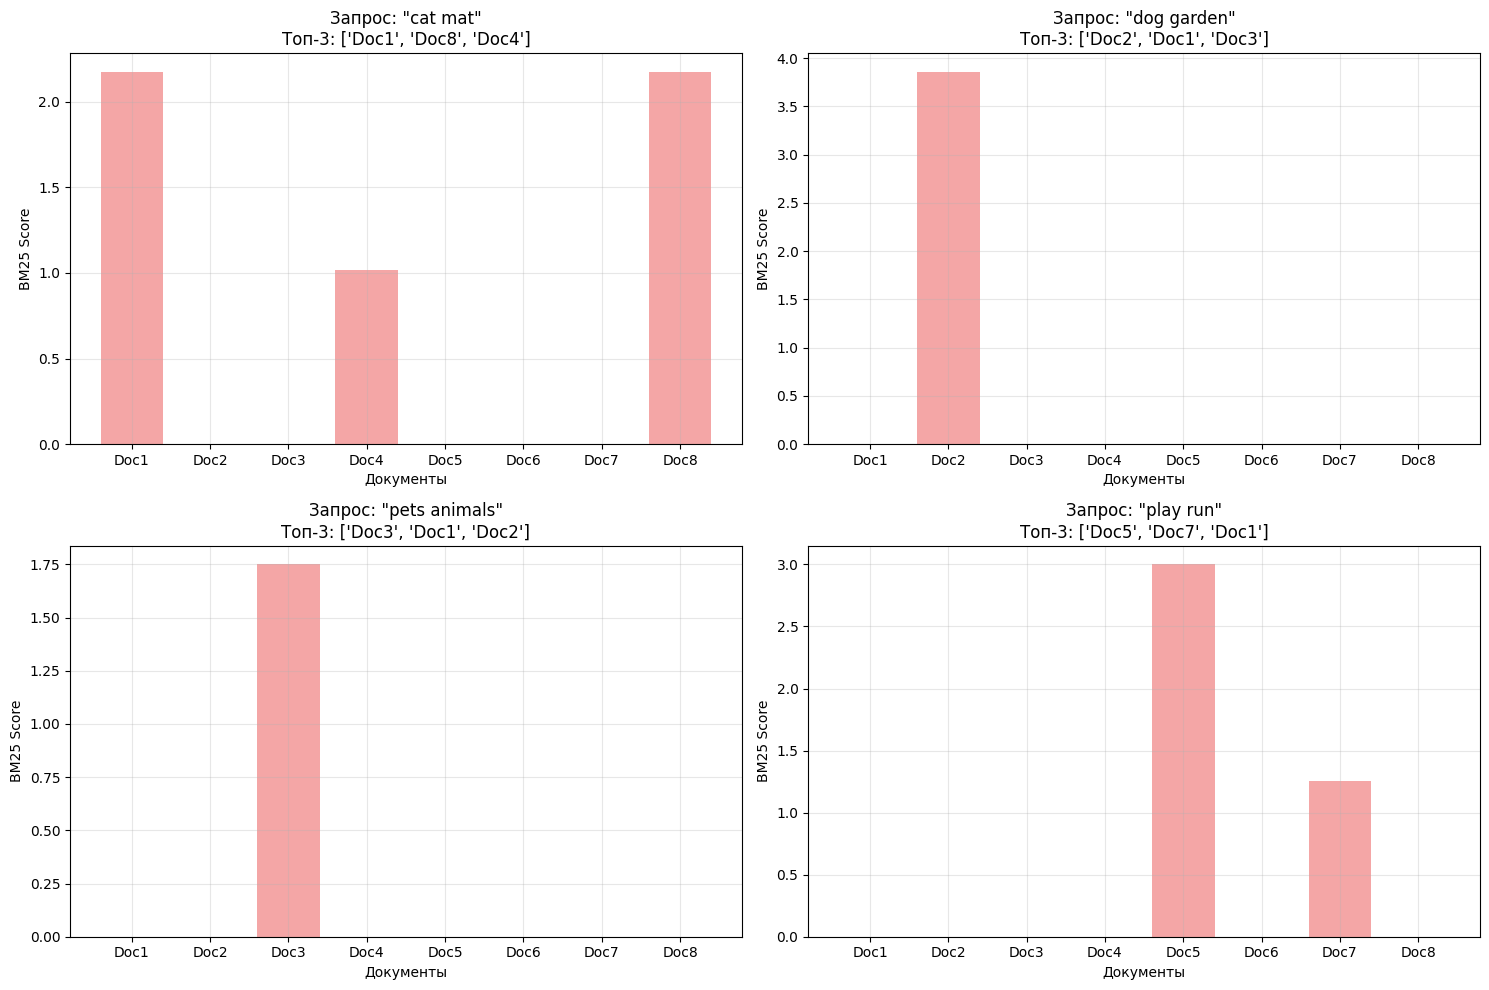

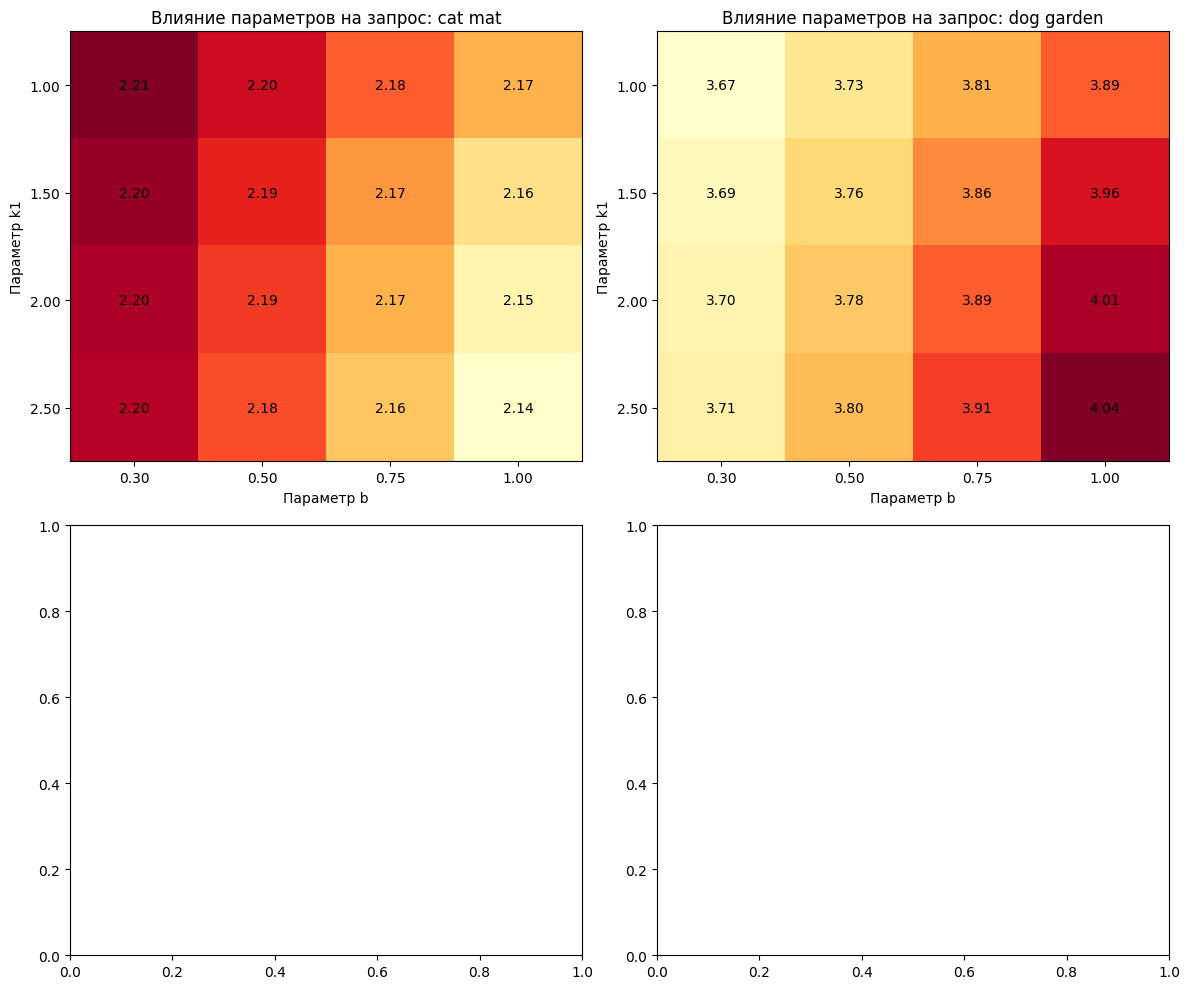

In [4]:
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from collections import defaultdict

class AdvancedBM25:
    def __init__(self, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        self.documents = []
        self.avgdl = 0
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = []
        self.corpus_size = 0

    def fit(self, documents):
        """Обучение модели на коллекции документов"""
        self.documents = documents
        self.corpus_size = len(documents)
        self.doc_len = [len(doc) for doc in documents]
        self.avgdl = np.mean(self.doc_len) if self.corpus_size > 0 else 0

        # Вычисление частот терминов
        tf = []
        df = defaultdict(int)

        for doc in documents:
            frequencies = {}
            for word in doc:
                frequencies[word] = frequencies.get(word, 0) + 1
                df[word] += 1
            tf.append(frequencies)

        self.doc_freqs = tf

        # Вычисление IDF с защитой от деления на ноль
        for word, freq in df.items():
            # Формула IDF из Okapi BM25
            self.idf[word] = math.log(
                (self.corpus_size - freq + 0.5) / (freq + 0.5) + 1
            )

    def get_score(self, query, doc_index):
        """Вычисление BM25 score для документа"""
        score = 0.0
        doc_length = self.doc_len[doc_index]

        for word in query:
            if word not in self.doc_freqs[doc_index]:
                continue

            tf = self.doc_freqs[doc_index][word]
            idf = self.idf.get(word, 0)

            # Формула BM25
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * (1 - self.b + self.b * doc_length / self.avgdl)

            score += idf * (numerator / denominator)

        return score

    def get_scores(self, query):
        """Вычисление BM25 scores для всех документов"""
        return [self.get_score(query, i) for i in range(self.corpus_size)]

    def search(self, query, top_k=None):
        """Поиск топ-K документов по запросу"""
        scores = self.get_scores(query)
        scored_docs = list(zip(range(len(scores)), scores))
        scored_docs.sort(key=lambda x: x[1], reverse=True)

        if top_k is not None:
            return scored_docs[:top_k]
        return scored_docs

def advanced_tokenize(text, language='english'):
    """Продвинутая токенизация без внешних зависимостей"""
    # Базовые стоп-слова для разных языков
    stop_words = {
        'english': {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to',
            'for', 'of', 'with', 'by', 'as', 'is', 'are', 'was', 'were',
            'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
            'will', 'would', 'could', 'should', 'may', 'might', 'must',
            'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it',
            'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your',
            'his', 'its', 'our', 'their', 'what', 'which', 'who', 'whom'
        },
        'russian': {
            'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как',
            'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к',
            'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было',
            'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь'
        }
    }

    # Выбор стоп-слов по языку
    current_stop_words = stop_words.get(language, stop_words['english'])

    # Токенизация с помощью регулярных выражений
    words = re.findall(r'\b[a-zA-Zа-яА-Я]+\b', text.lower())

    # Фильтрация стоп-слов и коротких токенов
    tokens = [word for word in words if word not in current_stop_words and len(word) > 2]

    return tokens

# Демонстрация работы
def demonstrate_bm25():
    """Демонстрация работы BM25 с разными запросами"""

    # Корпус документов
    documents = [
        "The cat sat on the mat and looked outside",
        "The dog played in the garden with a ball",
        "Cats and dogs are common household pets",
        "The red mat is on the wooden floor",
        "Dogs like to play and run in gardens",
        "Cats often sleep on comfortable mats",
        "Gardens are great places for dogs to play",
        "The little cat sat on the big mat"
    ]

    # Токенизация
    processed_docs = [advanced_tokenize(doc) for doc in documents]

    print("Обработанные документы:")
    for i, doc in enumerate(processed_docs):
        print(f"Doc {i+1}: {doc}")

    # Создание и обучение модели
    bm25 = AdvancedBM25(k1=1.5, b=0.75)
    bm25.fit(processed_docs)

    # Тестовые запросы
    test_queries = [
        "cat mat",
        "dog garden",
        "pets animals",
        "play run"
    ]

    # Визуализация результатов
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, query in enumerate(test_queries):
        if idx >= len(axes):
            break

        query_tokens = advanced_tokenize(query)
        scores = bm25.get_scores(query_tokens)

        # Поиск топ-3 документов
        top_docs = bm25.search(query_tokens, top_k=3)

        # Визуализация
        axes[idx].bar(range(len(scores)), scores, color='lightcoral', alpha=0.7)
        axes[idx].set_title(f'Запрос: "{query}"\nТоп-3: {[f"Doc{x[0]+1}" for x in top_docs]}')
        axes[idx].set_xlabel('Документы')
        axes[idx].set_ylabel('BM25 Score')
        axes[idx].set_xticks(range(len(scores)))
        axes[idx].set_xticklabels([f'Doc{i+1}' for i in range(len(scores))])
        axes[idx].grid(True, alpha=0.3)

        print(f"\nЗапрос: '{query}'")
        print("Топ-3 документа:")
        for doc_idx, score in top_docs:
            print(f"  Doc{doc_idx + 1}: {score:.4f} - '{documents[doc_idx]}'")

    plt.tight_layout()
    plt.show()

    # Анализ влияния параметров
    analyze_parameters(processed_docs)

def analyze_parameters(documents):
    """Анализ влияния параметров k1 и b на BM25"""
    queries = [['cat', 'mat'], ['dog', 'garden']]

    # Тестирование разных параметров
    k1_values = [1.0, 1.5, 2.0, 2.5]
    b_values = [0.3, 0.5, 0.75, 1.0]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for query_idx, query in enumerate(queries):
        if query_idx >= len(axes):
            break

        scores_matrix = []

        for k1 in k1_values:
            row_scores = []
            for b in b_values:
                bm25 = AdvancedBM25(k1=k1, b=b)
                bm25.fit(documents)
                scores = bm25.get_scores(query)
                row_scores.append(np.max(scores))  # Берем максимальный score
            scores_matrix.append(row_scores)

        # Heatmap влияния параметров
        im = axes[query_idx].imshow(scores_matrix, cmap='YlOrRd', aspect='auto')
        axes[query_idx].set_title(f'Влияние параметров на запрос: {" ".join(query)}')
        axes[query_idx].set_xlabel('Параметр b')
        axes[query_idx].set_ylabel('Параметр k1')
        axes[query_idx].set_xticks(range(len(b_values)))
        axes[query_idx].set_yticks(range(len(k1_values)))
        axes[query_idx].set_xticklabels([f'{b:.2f}' for b in b_values])
        axes[query_idx].set_yticklabels([f'{k1:.2f}' for k1 in k1_values])

        # Добавление значений в ячейки
        for i in range(len(k1_values)):
            for j in range(len(b_values)):
                axes[query_idx].text(j, i, f'{scores_matrix[i][j]:.2f}',
                                   ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

# Запуск демонстрации
if __name__ == "__main__":
    demonstrate_bm25()